## Project: Predicting Boston Housing Prices
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

## Getting Started
Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. We will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import *

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Initialize Spark and SQL Contexts
spark_context = SparkContext()
sc = SQLContext(spark_context)

# Load the Boston housing dataset
data = sc.read.csv('housing.csv', header=True, inferSchema=True)
prices = data.select('MEDV')
features = data.drop('MEDV')

data.cache()
prices.cache()
features.cache()

# Success
print("Boston housing dataset has {} data points with {} variables each.".format(data.count(), len(data.columns)))

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, we will make a cursory investigation about the Boston housing data and provide our observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help better understand and justify the results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
We will calculate descriptive statistics about the Boston housing prices. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, we have implemented the following:
- Calculated the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Stored each calculation in their respective variable.

In [2]:
# Minimum price of the data
minimum_price = prices.agg({'MEDV':'min'}).collect()[0]['min(MEDV)']

# Maximum price of the data
maximum_price = prices.agg({'MEDV':'max'}).collect()[0]['max(MEDV)']

# Mean price of the data
mean_price = prices.agg({'MEDV':'avg'}).collect()[0]['avg(MEDV)']

# Median price of the data
median_price = prices.approxQuantile('MEDV', [0.5], 0)[0]

# Standard deviation of prices of the data
std_price = prices.agg({'MEDV':'stddev_pop'}).collect()[0]['stddev_pop(MEDV)']

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.


** Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each.**

**Hint:** This problem can be phrased using examples like below.  
* Would you expect a home that has an `'RM'` value(number of rooms) of 6 be worth more or less than a home that has an `'RM'` value of 7?
* Would you expect a neighborhood that has an `'LSTAT'` value(percent of lower class workers) of 15 have home prices be worth more or less than a neighborhood that has an `'LSTAT'` value of 20?
* Would you expect a neighborhood that has an `'PTRATIO'` value(ratio of students to teachers) of 10 have home prices be worth more or less than a neighborhood that has an `'PTRATIO'` value of 15?

**Answer: **

**'RM':** More number of rooms mean high price, because the area of the plot on which the house is may be more than the one with lesser rooms. The designing and construction of the house would also have cost more, which justifies the high price.

**'LSTAT':** The higher the percentage of lower class homeowners, the lesser the price of the house. This is because the prices of the neighbouring houses also have an impact on the price of the house based on demand and the class of the people trying to buy the house in that area.

**'PTRATIO':** Lower PTRATIO could signify good education settings in the nearby schools, which increases the demand of such areas and the houses in these areas, which means an increase in the price.

----

## Developing a Model
In this second section of the project, we have developed the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in our predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we have calculated the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, we have implemented the following:
- Used `r2` from `RegressionEvaluator` in the `pyspark.ml.evaluation` module to perform a performance calculation between `true_and_predicted`.
- Assigned the performance score to the `score` variable.

In [3]:
# Import 'RegressionMetrics'
from pyspark.ml.evaluation import RegressionEvaluator


def performance_metric(true_and_predicted):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'true' and 'predictions'
    score = RegressionEvaluator(labelCol='true', predictionCol='predictions', metricName='r2').evaluate(true_and_predicted)

    # Return the score
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [4]:
# Calculate the performance of this model
sample_vals = list(zip([3.0, -0.5, 2.0, 7.0, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3]))
sample_data = sc.createDataFrame(sample_vals, ['true_vals', 'predictions'])
score = performance_metric(sample_data.selectExpr('true_vals as true', 'predictions'))
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


* Would you consider this model to have successfully captured the variation of the target variable? 
* Why or why not?

** Hint: **  The R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable. In other words:
* R2 score of 0 means that the dependent variable cannot be predicted from the independent variable.
* R2 score of 1 means the dependent variable can be predicted from the independent variable.
* R2 score between 0 and 1 indicates the extent to which the dependent variable is predictable. An 
* R2 score of 0.40 means that 40 percent of the variance in Y is predictable from X.

**Answer:**

A high R2 score of 0.923 for the model indicates that it has successfully captured 92.3% of the variation of the target variable.

### Implementation: Shuffle and Split Data
Our next implementation requires that we take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we have implemented the following:
- Used `randomSplit` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `seed` to a value of our choice. This ensures results are consistent.
- Assigned the train and testing splits to `train` and `test`.

In [5]:
# Shuffle and split the data into training and testing subsets
train, test = data.randomSplit([0.8, 0.2], 7777777)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Question 3 - Training and Testing

* What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?

**Hint:** Think about how overfitting or underfitting is contingent upon how splits on data is done.

**Answer: **

The benefit of splitting a dataset into some ratio is to train a model on the larger portion and to use the smaller portion as unseen data. This said portion of unseen data is used for testing the models performance. Using all of the data for training could result in models which might overfit or underfit on the unseen data. Therefore, we ensure that the model does good using a portion of the data we have for testing.

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing a model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

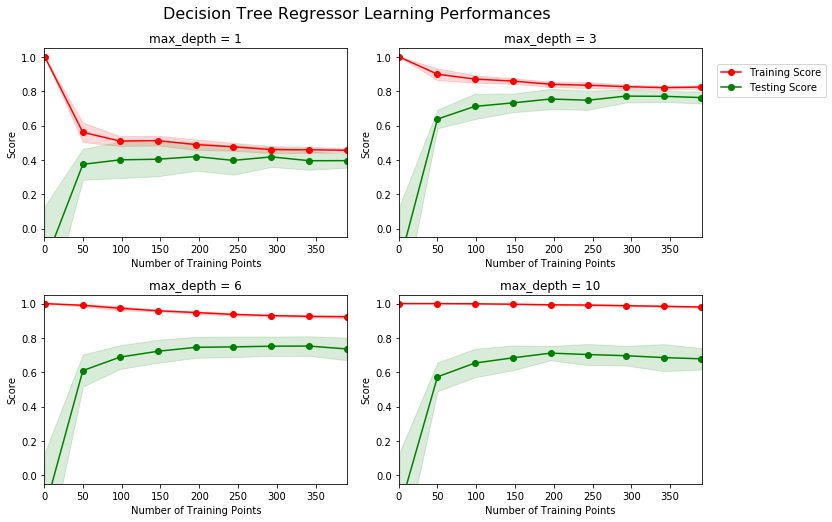

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features.toPandas(), prices.toPandas())

### Question 4 - Learning the Data
* Choose one of the graphs above and state the maximum depth for the model. 
* What happens to the score of the training curve as more training points are added? What about the testing curve? 
* Would having more training points benefit the model? 

**Hint:** Are the learning curves converging to particular scores? Generally speaking, the more data you have, the better. But if your training and testing curves are converging with a score above your benchmark threshold, would this be necessary?
Think about the pros and cons of adding more training points based on if the training and testing curves are converging.

**Answer: **
The graph with max_depth of 6 (bottom-left). The score of the training curve decreses in small amounts slowly for this graph to a certain point and then plateaus out. The testing curve on the other hand increases immensely for the first 50 samples and then slowly plateaus out. Adding more training points benefits the model only until the scores are still changing, after which the change in performance is trivial. If for a certain number of training points the model doesn't converge, then adding more training points is the best option. Thus, it will not be beneficial to add more training points in this case.

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

** Run the code cell below and use this graph to answer the following two questions Q5 and Q6. **

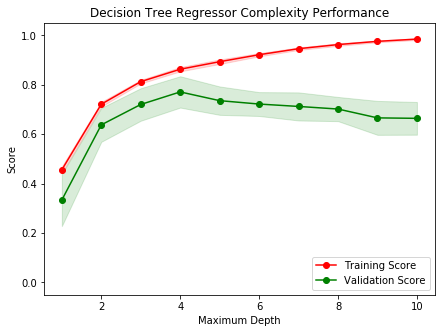

In [7]:
vs.ModelComplexity(train.drop('MEDV').toPandas(), train.select('MEDV').toPandas()['MEDV'])

### Question 5 - Bias-Variance Tradeoff
* When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? 
* How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Hint:** High bias is a sign of underfitting(model is not complex enough to pick up the nuances in the data) and high variance is a sign of overfitting(model is by-hearting the data and cannot generalize well). Think about which model(depth 1 or 10) aligns with which part of the tradeoff.

**Answer: ** Since a max_depth of 1 is not complex enough, and because the scores are too low and still increasing, I would say that the model suffers from high bias (underfitting). For the model with max_depth set to 10, the training and validation scores are growing far apart and the fact that the validation score begins to decrease are the signs that the model is beginning to memorize the training data and only performs well on that data. This means that the model is suffering from high variance (overfitting).

### Question 6 - Best-Guess Optimal Model
* Which maximum depth do you think results in a model that best generalizes to unseen data? 
* What intuition lead you to this answer?

** Hint: ** Look at the graph above Question 5 and see where the validation scores lie for the various depths that have been assigned to the model. Does it get better with increased depth? At what point do we get our best validation score without overcomplicating our model? And remember, Occams Razor states "Among competing hypotheses, the one with the fewest assumptions should be selected."

**Answer: ** Based on the graph above, the optimal model is the one with the max_depth parameter set to 4, since this is the point where the training and validation scores begin to fall far apart.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
* What is the grid search technique?
* How it can be applied to optimize a learning algorithm?

** Hint: ** When explaining the Grid Search technique, be sure to touch upon why it is used,  what the 'grid' entails and what the end goal of this method is. To solidify your answer, you can also give an example of a parameter in a model that can be optimized using this approach.

**Answer: ** Grid search is a technique where we define a set of values for a set of parameters, build models to test the performance of the model on all the combinations of these parameters, and choose an optimal value for each parameter in the set of parameters. The word 'grid' refers to the combinations of the set of parameters that we define. For example, to build an optimal decision tree model, one of the parameters we can set values for is the max_depth paramter as above, and try all values between 1 and 10 and produce the graph as done above to determine the optimal max_depth.

### Question 8 - Cross-Validation

* What is the k-fold cross-validation training technique? 

* What benefit does this technique provide for grid search when optimizing a model?

**Hint:** When explaining the k-fold cross validation technique, be sure to touch upon what 'k' is, how the dataset is split into different parts for training and testing and the number of times it is run based on the 'k' value.

When thinking about how k-fold cross validation helps grid search, think about the main drawbacks of grid search which are hinged upon **using a particular subset of data for training or testing** and how k-fold cv could help alleviate that. You can refer to the [docs](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for your answer.

**Answer: ** In k-fold cross-validation, we divide the data into k parts, we train and test models for k iterations where each iteration uses a different part as it's testing data and the remaining k-1 parts as training data. Finally, the average of the score obtained after each iteration is used as the overall performance of that model.
In case of grid search, cross-validation helps us determine the performance of a combination of parameter values on various training and test sets. If we were to use a particular subset of data, then the model would be considered vastly under-represented. If the training data in this particular subset did not capture all of the data in the dataset, then it would perform poorly on the test set and the parameter setting would be discarded. On the other hand if the test set contained data which was already modeled in the training phase, then the model would perform extremely well on the test data and these parameters would be chosen. This can be overcome by performing grid search along with k-fold cross validation where multiple combinations of training and test sets ensure the goodness of the parameter setting.

### Implementation: Fitting a Model
Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

We are using `CrossValidator` from `pyspark.ml.tuning` module to perform cross-validation.

In addition, we are using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique described in **Question 8**, this type of cross-validation technique is just as useful!. The `CrossValidator` implementation below will create 10 shuffled sets, and for each shuffle, 20% of the data will be used as the *validation set*.

For the `fit_model` function in the code cell below, we have implemented the following:
- Used [`Pipeline`](https://spark.apache.org/docs/2.1.1/ml-pipeline.html) from `pyspark.ml` to create a pipeline object.
  - Defined stages for the pipeline to convert the features to vectors and train a Decision Tree.
  - Used [`DecisionTreeRegressor`](https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#decision-tree-regression) from `pyspark.ml.regression` to create a decision tree regressor object.
- Created a Parameter Grid for `'max_depth'` with the values from 1 to 10, using `ParamGridBuilder` from `pyspark.ml.tuning` module,  and assigned this to the `'params'` variable.
- Used [`CrossValidator`](https://spark.apache.org/docs/2.1.0/ml-tuning.html) from `pyspark.ml.tuning` to perform 10-fold Cross-Validation.

In [8]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


def fit_model(train_data):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Automatically identify categorical features, and index them.
    feature_assembler = VectorAssembler(inputCols=['RM', 'LSTAT', 'PTRATIO'], outputCol='features')

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(featuresCol='features', labelCol='MEDV', predictionCol='predictions')

    # Configure an ML Pipeline, which consists of three stages: feature_assembler, feature_indexer, and regressor
    dt_pipeline = Pipeline(stages=[feature_assembler, regressor])

    # Create a Parameter Grid for the parameter 'max_depth' with a range from 1 to 10
    params = ParamGridBuilder().addGrid(regressor.maxDepth, list(range(1, 11))).build()

    # We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. 
    cross_validator = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=params, evaluator=RegressionEvaluator(labelCol='MEDV', predictionCol='predictions', metricName='r2'), numFolds=10, seed=17325)

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_validator.fit(train_data)

    # Return the optimal model after fitting the data
    return cv_model.bestModel

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model

* What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [9]:
# Fit the training data to the model using grid search
reg = fit_model(train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.stages[1]._java_obj.getMaxDepth()))

Parameter 'max_depth' is 4 for the optimal model.


** Hint: ** The answer comes from the output of the code snipped above.

**Answer: ** The model has an optimal maximum depth of 4, same as I guessed.

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* What price would you recommend each client sell his/her home at? 
* Do these prices seem reasonable given the values for the respective features? 

**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  Of the three clients, client 3 has has the biggest house, in the best public school neighborhood with the lowest poverty level; while client 2 has the smallest house, in a neighborhood with a relatively high poverty rate and not the best public schools.

Run the code block below to have your optimized model make predictions for each client's home.

In [10]:
# Produce a DataFrame for client data
client_data = sc.createDataFrame([(5, 17, 15), # Client 1
                                  (4, 32, 22), # Client 2
                                  (8, 3, 12)], ['RM', 'LSTAT', 'PTRATIO'])  # Client 3

# Show predictions
for i, price in enumerate(reg.transform(client_data).select('predictions').collect()):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price['predictions']))

Predicted selling price for Client 1's home: $407,925.00
Predicted selling price for Client 2's home: $224,927.03
Predicted selling price for Client 3's home: $958,500.00


**Answer: ** 
I would recommend the prices predicted above. In the case of client-1, the feature values are all close to the average and so the predicted price is close to mean. In case of client-2, the feature values belong to the lower extreme. Therefore, the predicted price is close to the minimum price. For client-3, the feature values belong to the higher extreme. Therefor, the predicted price is a little lesser than the maximum price.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. 

**Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with respect to the data it's trained on.**

In [11]:
def predict_trials(data_input, fitter, clients):
    """ Performs trials of fitting and predicting data. """
    from builtins import max, min
    
    # Store the predicted prices
    prices = []
    
    for k in range(10):
        # Split the data
        train_data, test_data = data_input.randomSplit([0.8, 0.2], seed=135679+k)
        
        # Fit the data
        reg = fitter(train_data)
        
        # Make a prediction and print the result
        pred = reg.transform(clients).collect()[0]['predictions']
        print("Trial {}: ${:,.2f}".format(k+1, pred))
        prices.append(pred)

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))


predict_trials(data, fit_model, client_data)

Trial 1: $424,637.50
Trial 2: $409,762.50
Trial 3: $414,820.00
Trial 4: $384,490.91
Trial 5: $418,250.00
Trial 6: $415,322.73
Trial 7: $408,887.50
Trial 8: $432,133.33
Trial 9: $415,895.45
Trial 10: $413,082.35

Range in prices: $47,642.42


In [12]:
spark_context.stop()

### Question 11 - Applicability

* In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.  

**Hint:** Take a look at the range in prices as calculated in the code snippet above. Some questions to answering:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answer: **
Data collected in 1978 could be useful if combined with all data from 1978 to present. Modelling inflation is important since it affects the prices of the houses. The features are insufficient because there are several other factors that attract or repel potential homeowners and also affect the prices. Yes, factors like pool, plot area, etc must be factored in to increase the accuracy of the predictions. No, the model is not robust enough to make consitent predictions due to lack of important features in the data. Data collected in urban cities will be trivial in predicting the prices of houses in a rural city. It is fair to judge the price of an individual home based on the neighbourhood, since the neighbourhood does play a major role in attracting potential clients. Based on the above discussion, I conclude that this model cannot be used in the real-world setting.